##**Import requiered libraries**

In [ ]:
!pip install opencv-contrib-python==4.4.0.44
import numpy as np
import cv2 
import matplotlib.pyplot as plt

##**read images**

In [ ]:
image1=plt.imread("/content/01.JPG")
image2=plt.imread("/content/02.JPG")
h,w=np.array(image1).shape[:2]

plt.subplot(1,2,1)
plt.title("image1")
plt.imshow(image1)


plt.subplot(1,2,2)
plt.imshow(image2)
plt.title("image2")
plt.show()

##**Find corresponding points**


In [ ]:
# ---find the keypoints and descriptors with SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1,None)
kp2, des2 = sift.detectAndCompute(image2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
pts1 = np.float32([ kp1[m.queryIdx].pt for m in good ])
pts2 = np.float32([ kp2[m.trainIdx].pt for m in good ])
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

#----find fundamental matrix
F, mask=cv2.findFundamentalMat(pts1, pts2,cv2.FM_RANSAC,
                                ransacReprojThreshold=3,
                                confidence=0.995)
print(F)

[[ 1.18242991e-08 -1.00299161e-07 -1.30372712e-04]
 [-4.25888900e-08  1.90618310e-08 -1.41175244e-03]
 [-2.29079187e-04  1.66562844e-03  1.00000000e+00]]


##**Fundamental matrix**

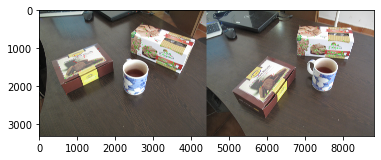

In [ ]:
#  inlier points
pts1_inlier = pts1[mask.ravel()==1]
pts2_inlier = pts2[mask.ravel()==1]

#  outlier points
pts1_outlier = pts1[mask.ravel()==0]
pts2_outlier = pts2[mask.ravel()==0]

image1_with_points=np.copy(image1)
for cor in pts1_inlier:
    image1_with_points = cv2.circle(image1_with_points, (cor[0],cor[1]), radius=3, color=(0,255,0), thickness=3)
for cor in pts1_outlier:
    image1_with_points = cv2.circle(image1_with_points, (cor[0],cor[1]), radius=3, color=(255,0,0), thickness=3)    

image2_with_points=np.copy(image2)
for cor in pts2_inlier:
    image2_with_points = cv2.circle(image2_with_points, (cor[0],cor[1]), radius=3, color=(0,255,0), thickness=3)
for cor in pts2_outlier:
    image2_with_points = cv2.circle(image2_with_points, (cor[0],cor[1]), radius=3, color=(255,0,0), thickness=3)  

im_horizental = cv2.hconcat([image1_with_points, image2_with_points])
plt.imshow(im_horizental)
plt.imsave("res05.jpg",im_horizental)
plt.show()

##**Svd decomposition**

In [ ]:
def svd_decom(matrice):
    u, s, vh = np.linalg.svd(matrice, full_matrices=True)
    h=np.zeros([3,1])
    v=(np.array(vh).transpose())  #answer is the last column of v in svd decompostion
    row,colum=v.shape
    h=v[:,colum-1]
    h/=h[-1]
    return h

In [ ]:
e=svd_decom(F)
F_prime=np.array(F).transpose()
e_prime=svd_decom(F_prime)
print(f"e is : {e}")
print(f"e_prime is : {e_prime}")

e is : [-3.56090667e+04 -5.49780240e+03  1.00000000e+00]
e_prime is : [ 1.64524707e+04 -8.11015580e+02  1.00000000e+00]


##**show epipoles in two images**

In [ ]:
#plot and save res06 and res07
plt.imshow(image1)
plt.scatter(e[0], e[1], s=5, label='x', marker='+')
plt.savefig("res06.jpg")
plt.show()

plt.imshow(image2)
plt.scatter(e_prime[0], e_prime[1], s=5, label='x', marker='+')
plt.savefig("res07.jpg")

##**line**

In [ ]:
def line(slope_mat):
    point1=(0,int(-slope_mat[2]/slope_mat[1]))
    point2=(5000,int((-slope_mat[2]-5000*slope_mat[0])/slope_mat[1]))
    return point1,point2

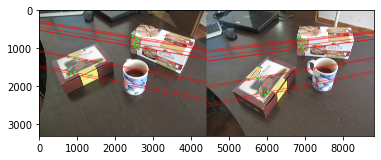

In [ ]:
import random
res08_1=np.copy(image1)
res08_2=np.copy(image2)
for i in range(10):
    x = random.randint(0,100)

    pt1,pt2=line(np.dot(np.array(F).transpose(),[pts2_inlier[x][0],pts2_inlier[x][1],1]))
    res08_1 = cv2.line(res08_1, pt1, pt2, color=(255,0,0), thickness=10)

    pt1,pt2=line(np.dot(F,[pts1_inlier[x][0],pts1_inlier[x][1],1]))
    res08_2 = cv2.line(res08_2, pt1, pt2, color=(255,0,0), thickness=10)

    res08_1 = cv2.circle(res08_1, (pts1_inlier[x][0],pts1_inlier[x][1]), radius=20, color=(0,255,0), thickness=20)
    res08_2 = cv2.circle(res08_2, (pts2_inlier[x][0],pts2_inlier[x][1]), radius=20, color=(0,255,0), thickness=20)

concate = cv2.hconcat([res08_1, res08_2])
plt.imshow(concate)
plt.imsave("res08.jpg",concate)
plt.show()